In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from patsy import dmatrices

# 1. Data Preparation

## 1.1 Metropolitan Police use of Force Data

The data to be used for the majority of the analysis is the Met Police Use of Force data. It can be accessed here: https://data.london.gov.uk/dataset/use-of-force

Recording of this data began in April 2017, so this is where the analysis will begin, and it will cover 4 complete years up until April 2021. There is more up to date data available, however, it was chosen to only go to April 2021 rather than also including the next data set that runs until the present day, as this data is still subject to change and so may be inaccurate.

In [8]:
# Reading data from 4 years and parsing date and time into one column

# 2017 is in format DD/MM/YY which is different from other files, using custom date parser so it is in right format
custom_date_parser = lambda x, y: pd.to_datetime(x+" "+y).strftime("%d/%m/%Y %H:%M:%S")

force17 = pd.read_csv("MPS Use of Force - FY17-18.csv", parse_dates={"DateTime": ['IncidentDate', 'IncidentTime']}, 
                      date_parser=custom_date_parser, low_memory=False)
force18 = pd.read_csv("MPS Use of Force - FY18-19.csv", parse_dates={"DateTime": ['IncidentDate', 'IncidentTime']}, 
                      low_memory=False)
force19 = pd.read_csv("MPS Use of Force - FY19-20.csv", parse_dates={"DateTime": ['IncidentDate', 'IncidentTime']}, 
                      low_memory=False)
force20 = pd.read_csv("MPS Use of Force - FY20-21.csv", parse_dates={"DateTime": ['IncidentDate', 'IncidentTime']}, 
                      low_memory=False)

In [350]:
# Combining the data from 4 years into one dataframe containing the raw data and examining
force_raw = pd.concat([force17, force18, force19, force20], ignore_index=True)
force_raw.head()

,DateTime,Incident Location: Street/Highway,Incident Location: Public Transport,Incident Location: Retail Premises,"Incident Location: Open ground (e.g. park, car park, field)",Incident Location: Licensed Premises,Incident Location: Sports or Event Stadia,Incident Location: Hospital/A&E (non-mental-health setting),Incident Location: Mental Health Setting,Incident Location: Police vehicle with prisoner handling cage,...,SubjectMedOffered,SubjectMedProvided,Outcome: Made off/escaped,Outcome: Arrested,Outcome: Hospitalised,Outcome: Detained - Mental Health Act,Outcome: Fatality,Outcome: Other,CED Used,CED Device Serial No
0,2017-04-01 00:42:00,No,No,No,No,Yes,No,No,No,No,...,NaN,NaN,No,Yes,No,No,No,No,NaN,NaN
1,2017-04-01 04:15:00,Yes,No,No,No,No,No,No,No,No,...,NaN,NaN,No,Yes,No,No,No,No,NaN,NaN
2,2017-04-01 03:55:00,Yes,No,No,No,No,No,No,No,No,...,NaN,NaN,No,Yes,No,No,No,No,NaN,NaN
3,2017-04-01 04:10:00,Yes,No,No,No,No,No,No,No,No,...,NaN,NaN,No,Yes,No,No,No,No,NaN,NaN
4,2017-04-01 11:29:00,Yes,No,No,No,No,No,No,No,No,...,NaN,NaN,No,Yes,No,No,No,No,NaN,NaN


In [349]:
# Changing the Yes and No columns to 1s and 0s for easier analysis
force_encoded = force_raw.replace(to_replace=['No', 'Yes'], value=[0, 1])

# Replacing NaN values with 0
force_encoded = force_encoded.fillna(0)

# Examining columns
# force_encoded.columns.values

There are several column names, especially those relating to 'Tactics' and 'Effectives' that have not been adequately explained by the Metropolitan Police, so these will be excluded from further analysis. There are also numerous columns relating to specific usage of taser, however, this level of specificity does not provide much insight into the severity of the taser usage, so only the 7 broad categories of taser usage columns will be used, froma severity level of 0 (no taser usage) to 7 (CED Angle Drive Stun), as per the Metropolitan Police definitions, available at https://data.london.gov.uk/dataset/use-of-force.

In [11]:
taser_cols = ['CED Drawn',
       'CED Aimed', 'CED Red-Dotted', 'CED Arced','CED Drive Stun',
       'CED Fired', 'CED Angle Drive Stun']

In [12]:
# merging location into one column to reduce dimensionality
location_cols = ['Incident Location: Street/Highway',
       'Incident Location: Public Transport',
       'Incident Location: Retail Premises',
       'Incident Location: Open ground (e.g. park, car park, field)',
       'Incident Location: Licensed Premises',
       'Incident Location: Sports or Event Stadia',
       'Incident Location: Hospital/A&E (non-mental-health setting)',
       'Incident Location: Mental Health Setting',
       'Incident Location: Police vehicle with prisoner handling cage',
       'Incident Location: Police vehicle without prisoner handling cage',
       'Incident Location: Dwelling',
       'Incident Location: Police station (excluding custody block)',
       'Incident Location: Custody Block', 'Incident Location: Ambulance',
       'Incident Location: Other']
force_encoded['Location'] = force_encoded[location_cols].idxmax(axis=1).str.replace("Incident Location: ", "")

In [13]:
# encoding level of injury like other columns and renaming for clarity
injury = pd.get_dummies(force_encoded['SubjectNatureOfInjury'])

current_cols = injury.columns.values
desired_cols = ['Injury: None', 'Injury: Death', 'Injury: Minor', 'Injury: Severe']
col_dict = dict(zip(current_cols, desired_cols))
injury = injury.rename(columns=col_dict)

force_encoded = pd.concat([force_encoded, injury], axis=1)

In [348]:
# selecting columns of interest for further analysis
columns = ['DateTime', 'Borough', 'Location','SubjectEthnicity','SubjectAge','SubjectGender', 
        'Injury: None', 'Injury: Death', 'Injury: Minor', 'Injury: Severe',
       'SubjectMedOffered', 'SubjectMedProvided', 'CED Drawn',
       'CED Aimed', 'CED Red-Dotted', 'CED Arced','CED Drive Stun',
       'CED Fired', 'CED Angle Drive Stun', 'Firearms Aimed', 'Firearms Fired',
       'Outcome: Made off/escaped', 'Outcome: Arrested',
       'Outcome: Hospitalised', 'Outcome: Detained - Mental Health Act',
       'Outcome: Fatality', 'Outcome: Other']

force_encoded = force_encoded[columns]
force_encoded.head()

,DateTime,Borough,Location,SubjectEthnicity,SubjectAge,SubjectGender,Injury: None,Injury: Death,Injury: Minor,Injury: Severe,...,CED Fired,CED Angle Drive Stun,Firearms Aimed,Firearms Fired,Outcome: Made off/escaped,Outcome: Arrested,Outcome: Hospitalised,Outcome: Detained - Mental Health Act,Outcome: Fatality,Outcome: Other
0,2017-04-01 00:42:00,City of Westminster,Licensed Premises,Other,18-34,Male,1,0,0,0,...,0.0,0.0,0,0,0,1,0,0,0,0
1,2017-04-01 04:15:00,Haringey,Street/Highway,White,35-49,Male,1,0,0,0,...,0.0,0.0,0,0,0,1,0,0,0,0
2,2017-04-01 03:55:00,Croydon,Street/Highway,White,18-34,Male,1,0,0,0,...,0.0,0.0,0,0,0,1,0,0,0,0
3,2017-04-01 04:10:00,Haringey,Street/Highway,White,18-34,Male,1,0,0,0,...,0.0,0.0,0,0,0,1,0,0,0,0
4,2017-04-01 11:29:00,Haringey,Street/Highway,Other,35-49,Male,1,0,0,0,...,0.0,0.0,0,0,0,1,0,0,0,0


As described by the Met Police, this data is not a count of police force incidents, rather each row represents use of force by one officer on a subject, so each subject may be represented more than once if more than one officer was involved.

I want a count of individual police force incidents, so duplicate rows need to be dealt with, but I also want to keep information about the different types of force used against one subject, so some columns in the duplicate rows all need to be merged rather than just removing duplicates.

I will define duplicates as rows that happen in the same borough and location, against a person of the same age, gender, and ethnicity within one hour of each other. This may miss some rows that are technically duplicates if the incident was particularly long, but it will catch most of them.

In [15]:
# turning index into a column so that the index information isn't lost when grouping
force_encoded = force_encoded.reset_index()

# creating a new column with the incident time rounded to the nearest hour to check for duplicates
force_encoded['Rounded Time'] = force_encoded['DateTime'].round('1H')

# defining columns to check for duplication, and counting the percentage of duplicates
duplicate_check = ['Rounded Time', 'Borough', 'Location', 'SubjectAge', 'SubjectGender', 'SubjectEthnicity']
no_duplicates = force_encoded.duplicated(subset=duplicate_check).sum()
print("Percentage of dataset that is duplicates: {:.2f}%".format(no_duplicates*100/len(force_encoded)))

Percentage of dataset that is duplicates: 17.14%


In [17]:
# defining columns that need to be aggregated, i.e. all columns besides those being used to check duplication
agg_cols = [col for col in force_encoded.columns.values if not col in duplicate_check]

# defining aggregation method for each column: taking index and datetime of first duplicate instance
    # and taking max value of all other columns, which corresponds to taking a 1 or 0 depending if that column is true
agg_method = ['min' if col == 'index' or col == 'DateTime' else 'max' for col in agg_cols ]

agg_dict = dict(zip(agg_cols, agg_method))

# grouping the duplicates and aggregating the columns not used to check duplication as described
duplicate_grouping = force_encoded.groupby(duplicate_check).agg(agg_dict)

# resetting the index back to the index from original dataframe
duplicate_grouping = duplicate_grouping.set_index('index')

In [18]:
# readding the columns that were used to check duplication, apart from rounded time as it is no longer needed
    # as these were removed when resetting index
duplicate_check.remove('Rounded Time')
cols_readd = force_encoded[duplicate_check]

incidents = cols_readd.join(duplicate_grouping, how='right')

# checking that this method has dealt with the duplicate rows correctly by comparing to the .duplicated() function
print(len(force_encoded) - len(incidents))
print(no_duplicates)

91177
91177


Below is the fully cleaned data set of only individual incidents, in time order, that will be used for the analysis:

In [347]:
incidents.head()

,Borough,Location,SubjectAge,SubjectGender,SubjectEthnicity,DateTime,Injury: None,Injury: Death,Injury: Minor,Injury: Severe,...,CED Fired,CED Angle Drive Stun,Firearms Aimed,Firearms Fired,Outcome: Made off/escaped,Outcome: Arrested,Outcome: Hospitalised,Outcome: Detained - Mental Health Act,Outcome: Fatality,Outcome: Other
index,,,,,,,,,,,,,,,,,,,,,
51,Enfield,Street/Highway,18-34,Female,White,2017-04-01 00:02:00,1,0,0,0,...,0.0,0.0,0,0,0,1,0,0,0,0
63,Sutton,Custody Block,18-34,Female,White,2017-04-01 00:10:00,1,0,0,0,...,0.0,0.0,0,0,0,1,0,0,0,0
15,Brent,Dwelling,18-34,Male,Black (or Black British),2017-04-01 01:12:00,1,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,1
0,City of Westminster,Licensed Premises,18-34,Male,Other,2017-04-01 00:42:00,1,0,0,0,...,0.0,0.0,0,0,0,1,0,0,0,0
50,City of Westminster,Licensed Premises,18-34,Male,White,2017-04-01 00:45:00,1,0,0,0,...,0.0,0.0,0,0,0,1,0,0,0,0


## 1.2 ONS Population Estimates 

The dataset used to provide population estimates by ethnic group and borough will be the 2016 estimates from ONS https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationcharacteristicsresearchtables

This data will be used to contextualise the police Use of Force by ethnic group, as those numbers are relatively meaningless without comparison to London's population.

Unfortunately, population data is not produced frequently, so it is not possible to have time series data on population - detailed population data of London is only taken once a decade in the census. 2016 is the only population data estimate including ethnicity that could be found that is close to the time period of the Metropolitan Police data, which is why this data set was chosen, and luckily it is near the beggining of the range of the Met Police data, so should provide a good estimate, as population is unlikely to have changed considerably over a period of 1 to 5 years. However, it is still important to consider that population proportions by ethnicity may be changing which may impact the analysis - the only way to find this out would be to examine the 2021 census data when it is released in the future.

In [20]:
# reading data and simultaneously removing the comma in the numbers
population = pd.read_csv('population_by_ethnicity.csv',thousands=',')
population.head() # the population values are stored in 1000s

,Area Code,Area Name,2011 Census Supergroup,Total,White British,All Other White,Mixed / Multiple ethnic groups,Asian / Asian British,Black / African / Caribbean / Black British,Other ethnic group,Unnamed: 10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,England and Wales,NaN,58381.0,46424.0,3483.0,993.0,4459.0,1967.0,1055.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E92000001,England,NaN,55268.0,43519.0,3407.0,968.0,4396.0,1946.0,1032.0,NaN
4,E12000001,North East,NaN,2637.0,2470.0,40.0,14.0,78.0,17.0,18.0,NaN


In [21]:
# dropping the columns that aren't of use
population = population.drop(["2011 Census Supergroup", "Unnamed: 10"], axis=1)

# multiplying numeric columns by 1000 so they represent the actual population numbers
population[population.select_dtypes(include=['number']).columns] *= 1000

# combining White British and All Other White columns and dropping them
population['White'] = population['White British'] + population['All Other White']
population = population.drop(['White British', 'All Other White'], axis = 1)

# stripping leading whitespace from the beggining of the area names
population['Area Name'] = population['Area Name'].str.lstrip()

# defining a list of the London boroughs and selecting these only
boroughs = ['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden',
 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney',
 'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering', 'Hillingdon',
 'Hounslow', 'Islington', 'Kensington and Chelsea', 'Kingston upon Thames',
 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames',
 'Southwark', 'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster']
population_boroughs = population[population['Area Name'].isin(boroughs)]

# selecting the values for London overall 
population_london = population[population['Area Name'] == 'London']

In [22]:
population_london

,Area Code,Area Name,Total,Mixed / Multiple ethnic groups,Asian / Asian British,Black / African / Caribbean / Black British,Other ethnic group,White
221,E12000007,London,8769000.0,326000.0,1611000.0,1095000.0,531000.0,5206000.0


## 1.3 Public Perception Data

The next dataset used will be from The Mayor's Office for Policing And Crime (MOPAC), specifically their regular survey about public perceptions of the police. This data was actually quite hard to retrieve, and had to be downloaded from MOPAC's Public Voice Tableau Dashboard: https://www.london.gov.uk/what-we-do/mayors-office-policing-and-crime-mopac/data-and-statistics/public-voice-dashboard

The data is taken over time, and lines up with the period of the Met Police data.

In [344]:
# reading the data and examining questions ask to find which ones are of interest
perception = pd.read_csv('percept_demographic.csv', thousands=',')
perception.head()

,﻿Area,Characteristic,Date,Measure,Survey,Base,MPS Total,Number of Records,Proportion
0,Age,24 and under,31/12/2014,"""Good Job"" local - Police do a good job in the...",PAS,1303.0,NaN,1,64%
1,Age,24 and under,31/12/2014,Ward officer - Knows how to contact their loca...,PAS,1356.0,NaN,1,35%
2,Age,24 and under,31/12/2014,Informed local - Feels well informed about loc...,PAS,1277.0,NaN,1,38%
3,Age,24 and under,31/12/2014,Listen concerns - Agree the police listen to t...,PAS,1203.0,NaN,1,66%
4,Age,24 and under,31/12/2014,Relied on - Agree the police can be relied upo...,PAS,1314.0,NaN,1,75%


In [345]:
perception['Measure'].unique()

array(['"Good Job" local - Police do a good job in the local area',
       'Ward officer - Knows how to contact their local ward officer',
       'Informed local - Feels well informed about local police activities over the last 12 months',
       'Listen concerns - Agree the police listen to the concerns of local people',
       'Relied on - Agree the police can be relied upon to be there when needed',
       'Treat everyone fairly - Agree the police treat everyone fairly regardless of who they are',
       'Understand issues - Agree the police are dealing with the things that matter to this community'],
      dtype=object)

The only question that will be examined from this data is 'Agree the police treat everyone fairly regardless of who they are', as this is the one that most directly relates to the questions asked by this project.

In [346]:
# selecting only question of interest
perception = perception[perception['Measure'] 
                == 'Treat everyone fairly - Agree the police treat everyone fairly regardless of who they are']

# removing leading character from Area column name
perception = perception.rename(columns={'\ufeffArea':'Area'})

# selecting only groups relating to ethnicity, the key area of interest
perception = perception[perception['Area'] == 'Ethnicity'].reset_index()

# selecting columns of interest
columns = ['Characteristic', 'Date','Base', 'Proportion']
perception = perception[columns]

# formatting proportion column as a float
perception['Proportion'] = perception['Proportion'].str.rstrip('%').astype('float')

# formatting Date column as datetime object and only keeping dates in desired range
perception['Date'] =  pd.to_datetime(perception['Date'], format='%d/%m/%Y').dt.date

perception.head()

,Characteristic,Date,Base,Proportion
0,Asian,2014-12-31,1196.0,79.0
1,Black,2014-12-31,860.0,67.0
2,Mixed ethnicity,2014-12-31,196.0,63.0
3,Other,2014-12-31,170.0,80.0
4,White British,2014-12-31,3318.0,70.0


We can see that MOPAC has not provided the number of people surveyed (see 'Base' column) for most of the desired time range, so we will try to extrapolate some values.

<AxesSubplot:xlabel='Date', ylabel='Base'>

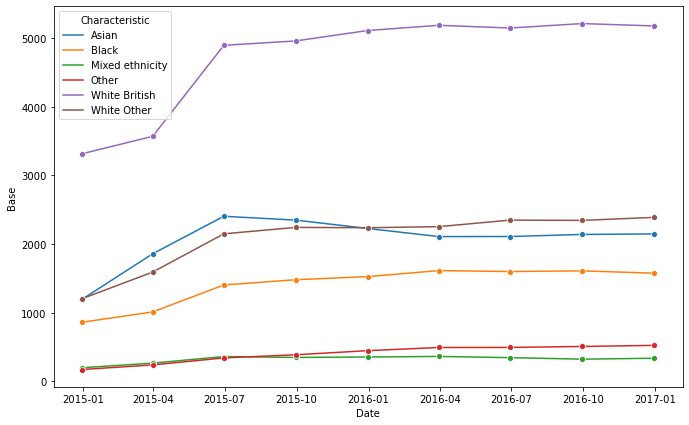

In [432]:
plt.figure(figsize=(7*1.61,7))
sns.lineplot(x=perception['Date'], y=perception['Base'], hue=perception['Characteristic'], marker='o')

The above figure shows that the number of people responding to the survey seems to be levelling out, so I will impute using the mean of all the points since 2015-07, since I do not see a reason why the number of respondents would change drastically over just a few years. However, it is important to note that this kind of imputation has limitations, especially as we are extrapolating the values from very few data points.

In [27]:
# setting range of base values to use for imputation
start_date = pd.to_datetime("2015-06-30").date()
end_date = pd.to_datetime("2017-01-01").date()
mean_range = perception[perception['Date']>=start_date]
mean_range = mean_range[mean_range['Date']<=end_date]

# calculating mean to nearest integer for each racial group and imputing
for char in perception['Characteristic'].unique():
    mean = mean_range[mean_range['Characteristic'] == char]['Base'].mean()
    perception[perception['Characteristic'] == char] =\
        perception[perception['Characteristic'] == char].fillna(value=round(mean))

## 1.4 Metropolitan Police Crime Data

The next dataset used will be the Metropoliatan Police's crime data. This is provided monthly, and gives the number of crimes in each borough in each crime category. This data will be used to see if there is a relationship between police use of force and crime, especially violent crime.

In [342]:
crime = pd.read_csv("Monthly Crime Borough Level Offs Type.csv")
crime.head()

,Borough,MajorText,MinorText,201201,201202,201203,201204,201205,201206,201207,...,202102,202103,202104,202105,202106,202107,202108,202109,202110,202111
0,Aviation Security(SO18),NaN,Distraction Burglary,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aviation Security(SO18),Burglary,Burglary - Business and Community,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,Aviation Security(SO18),Burglary,Burglary - Residential,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aviation Security(SO18),Criminal Damage,Criminal Damage To Dwelling,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aviation Security(SO18),Criminal Damage,Criminal Damage To Motor Vehicle,2,3,3,5,2,5,4,...,2,0,1,0,2,2,1,1,2,6


In [29]:
# getting months in desired range to match Use of Force Data
start_col = crime.columns.get_loc('201704')
end_col = crime.columns.get_loc('202103')

# getting borough, major text, and all columns in date range
col_indices = [0] + [1] + [i for i in range(start_col, end_col+1)]
crime = crime.iloc[:, col_indices]

# dropping crimes in Borough category "aviation security", as this analysis is only inetrested in the actual city
crime = crime[crime['Borough'] != 'Aviation Security(SO18)']

# grouping the crime by major crime type
crime_bytype = crime.groupby('MajorText').sum()

# changing the column names to datetime format, set at the last day of the month
col_names = crime_bytype.columns.values
cols_datetime = pd.to_datetime(col_names, format='%Y%m') + pd.offsets.MonthEnd()

col_dict = dict(zip(col_names, cols_datetime))
crime_bytype = crime_bytype.rename(columns = col_dict)

# transposing the dataframe so that time is the rows and crime type is the columns, and renaming columns to make sense
crime_bytype = crime_bytype.transpose().reset_index()
crime_bytype = crime_bytype.rename(columns={'index': 'Date'})

I am interested in the difference between violent crime and non-violent crime, so I will aggregate columns to get the totals for each of these categories, along with the total crime each month. I am defininf 'violent crime' as crime that falls into the category of 'Violence Against The Person', and all other categories will count as non-violent crime. The met police crime definitions can be seen here: https://www.met.police.uk/sd/stats-and-data/met/crime-type-definitions/

In [30]:
# creating dataframe summarising total crime by violent and non-violent each month
crime_totals = pd.DataFrame()
total_cols = crime_bytype.columns.values.tolist()
total_cols.remove('Date')
non_violent_cols = total_cols[:]
non_violent_cols.remove('Violence Against the Person')

crime_totals['Date'] = crime_bytype['Date']
crime_totals['Violent Crime'] = crime_bytype['Violence Against the Person']
crime_totals['Non-Violent Crime'] = crime_bytype[non_violent_cols].sum(axis=1)
crime_totals['Total Crime'] = crime_bytype[total_cols].sum(axis=1)

crime_totals.head()

,Date,Violent Crime,Non-Violent Crime,Total Crime
0,2017-04-30,19614,45682,65296
1,2017-05-31,21937,49132,71069
2,2017-06-30,22929,47235,70164
3,2017-07-31,23268,50451,73719
4,2017-08-31,20459,49461,69920


# 2. Do people feel that the Metropolitan Police treat people fairly, regardless of race?

This section will use the police perception data to try and answer the key question above.

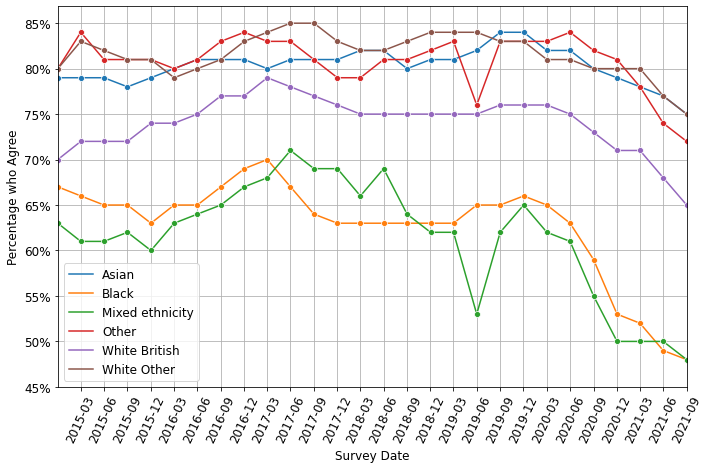

In [430]:
# Plotting the proportion of people who believe that the police treat people fairly, by, race, over time
plt.figure(figsize=(7*1.61,7))

axes = sns.lineplot(x=perception['Date'], y=perception['Proportion'], hue=perception['Characteristic'], marker ='o')

axes.xaxis.set_major_locator(mdates.MonthLocator(interval=3, bymonthday=30))
plt.xticks(fontsize = 12, rotation=65, ha='center')
plt.xlim(perception['Date'].iloc[0], perception['Date'].iloc[-1])

ylabs = [str(i) +'%' for i in range(45,90,5)]
ylocs = [i for i in range(45,90,5)]
plt.yticks(ylocs,ylabs, fontsize = 12)


plt.legend(fontsize = 12)
plt.xlabel('Survey Date', fontsize = 12)
plt.ylabel('Percentage who Agree', fontsize = 12)

plt.grid()
plt.show()

It can be seen that Mixed and Black people have a consistently lower proportion than other races.

I will now calculate a chi squared test to see if there is a significant statistical difference between different ethnicities' perception of the police, only including the most recent data point. To align with the Met Police categories, I will aggregate White British and White other for this calculation.

In [170]:
recent = perception[perception['Date']==pd.to_datetime('2021-09-30').date()]
recent = recent.assign(Agree = recent['Base']*recent['Proportion']/100)

recent['Disagree'] = recent['Base'] - recent['Agree']
contingency = recent.groupby('Characteristic')[['Agree','Disagree']].sum()

contingency.loc['White'] = contingency.loc['White British'] + contingency.loc['White Other']
contingency.drop(['White British', 'White Other'], inplace = True)
contingency

,Agree,Disagree
Characteristic,,
Asian,1659.75,553.25
Black,740.64,802.36
Mixed ethnicity,165.60,179.40
Other,326.88,127.12
White,5027.05,2355.95


In [173]:
stat, p, dof, expected = stats.chi2_contingency(contingency)
p

5.862518897162698e-80

The p value is much smaller than 0.01, so there is significant difference at the 99% confidence level. This means that there is a relationship between ethnicity, and agreeing or disagreeing that the police treat people fairly.

# 3. Do the Metropolitan Police use force fairly across different ethnic groups? 

This section will use the Use of Force data and the population data to answer the above question.

## 3.1 Proportion of Force Incidents by Ethnicity

In [33]:
# Getting incidents per ethnicity and renaming long ethnicity names
incidents_per_ethnicity = incidents['SubjectEthnicity'].value_counts()
incidents_per_ethnicity.rename({'Black (or Black British)':'Black', 'Asian (or Asian British)':'Asian'}, 
                               inplace = True)
incidents_per_ethnicity

White         186382
Black         153323
Asian          56147
Other          20763
Mixed          15717
Don't know      5688
Chinese         2604
Name: SubjectEthnicity, dtype: int64

Above are the number of incidents per ethnicity. The proportion of incidents per ethnicity will be compared to the proportion of each ethnicity in the population, to see if there is a difference. It is unclear why Chinese is a seperate category to Asian, but for my analysis these will be combined. It is important to note that these are not self-described ethnicities, but the ethnicity that the police officer reporting the incident thinks the subject is.

In [34]:
# Merging Chinese column with Asian and dropping it
incidents_per_ethnicity['Asian'] = incidents_per_ethnicity['Asian'] + incidents_per_ethnicity['Chinese']
incidents_per_ethnicity.drop('Chinese', inplace=True)
incidents_per_ethnicity

White         186382
Black         153323
Asian          58751
Other          20763
Mixed          15717
Don't know      5688
Name: SubjectEthnicity, dtype: int64

In [35]:
# calculating percentage of incidents by ethnicity
prop_per_ethnicity = incidents_per_ethnicity*100/len(incidents)

In [78]:
# extracting London population values and renaming ethnic groups to match met police categories
populations = population_london.drop(['Area Name', 'Area Code'], axis=1)

ethnicities = prop_per_ethnicity.index.values.tolist()
ethnicities.remove("Don't know")
cols_to_rename = ['White','Black / African / Caribbean / Black British', 'Asian / Asian British',
                  'Other ethnic group', 'Mixed / Multiple ethnic groups']
col_dict = dict(zip(cols_to_rename, ethnicities))
populations = populations.rename(columns=col_dict)

# calculating ethnicity proportions for London population
populations_prop = populations*100/populations['Total'].iloc[0]

# transposing and joining to incident proportions
populations_prop = populations_prop.transpose().rename(columns={221: 'Population'})

# merging two dataframes for comparison of incident proportions to population proportions
proportions = prop_per_ethnicity.to_frame().join(populations_prop).reset_index()
proportions = proportions.rename(columns={'SubjectEthnicity': 'Incidents', 'index': 'Ethnicity'})

proportions

,Ethnicity,Incidents,Population
0,White,42.299557,59.368229
1,Black,34.796788,12.487171
2,Asian,13.333591,18.371536
3,Other,4.712181,6.055423
4,Mixed,3.566987,3.717642
5,Don't know,1.290897,NaN


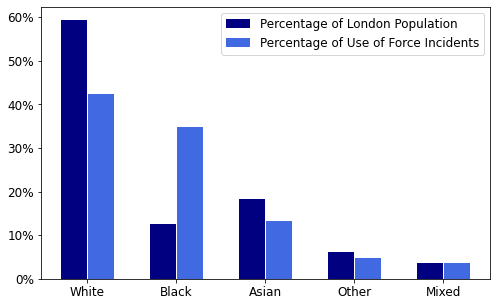

In [352]:
# Plotting bar chart comparing proportions of incidents vs population, excluding 'Don't know' category
    # and customising
    
pop = proportions['Population'].iloc[:5]
inc = proportions['Incidents'].iloc[:5]

ind = np.arange(5)

plt.figure(figsize=(5*1.61,5))

width = 0.3      

plt.bar(ind, pop , width-0.01, color = 'navy', label='Percentage of London Population')
plt.bar(ind + width, inc, width-0.01, color = 'royalblue', label='Percentage of Use of Force Incidents')

xlabs = ['White', 'Black', 'Asian', 'Other', 'Mixed']
plt.xticks(ind + width / 2, xlabs, fontsize = 12)

ylabs = [str(i) +'%' for i in range(0,61,10)]
ylocs = [i for i in range(0,61,10)]
plt.yticks(ylocs,ylabs, fontsize = 12)

plt.legend(fontsize = 12)
plt.show()


This shows that there is a disparity in police force incidents by race - even though black people only make up 12.5% of the population, they are the subjects of 34.8% of police force incidents.

Now I will conduct a t-test to confirm whether these resultsa are statistically significant. I will calculate the number of incidents per month per 1000 members of both black and non-black groups and run an independent t-test to see the significance.

In [304]:
# Renaming all non-black columns to NonBlack so that they combine when I groupby ethnicity
incidents_per_month = incidents.replace(to_replace=['Black (or Black British)',
                                                    'Asian (or Asian British)',
                                                    'White', 'Mixed', "Don't know", 'Chinese','Other'], 
                                                  value=['Black', 'NonBlack', 'NonBlack','NonBlack','NonBlack',
                                                        'NonBlack', 'NonBlack'])

# Grouping by month and ethnicity to get counts per month for black vs non black ethnicities
incidents_per_month = incidents_per_month.groupby([pd.Grouper(key='DateTime', freq='M'),'SubjectEthnicity'])\
                                                            ['Borough'].count().reset_index()

# renaming the column to make sense 
incidents_per_month = incidents_per_month.rename(columns={'Borough': 'Incidents'})

# calculating the number of incidents per 1000 people of that ethnic group per month
nonblack_pop = populations.loc['Total'][0] - populations.loc['Black'][0]
black_pop = populations.loc['Black'][0]
incidents_black_per1000 = (incidents_per_month[incidents_per_month['SubjectEthnicity'] == 'Black']['Incidents']\
                   /black_pop)*1000

incidents_nonblack_per1000 = (incidents_per_month[incidents_per_month['SubjectEthnicity'] == 'NonBlack']['Incidents']\
                   /nonblack_pop)*1000

# running the t-test
stats.ttest_ind(incidents_black_per1000, incidents_nonblack_per1000, alternative='greater')

Ttest_indResult(statistic=13.73808700421564, pvalue=1.663014505728693e-24)

The p-value is much less than 0.01, suggesting that this result is statistically significant at the 99% level.

## 3.2 Police Force Severity by Ethnicity

Now, I want to see if there is a difference in the severity of the police force incidents by race, to to this I will group by ethnicity, and then look at columns containing information about subject injuries, use of tasers, and use of firearms.

In [39]:
# Grouping by ethnicity and summing over all other columns to get counts
by_ethnicity = incidents.groupby('SubjectEthnicity').sum()

# Renaming long ethnicities
by_ethnicity.rename(index = {'Black (or Black British)':'Black', 'Asian (or Asian British)':'Asian'}, inplace=True)

# Aggregating Chinese and Asian categories, dropping Chinese
by_ethnicity.loc['Asian'] = by_ethnicity.loc['Asian'] + by_ethnicity.loc['Chinese']
by_ethnicity.drop('Chinese', inplace=True)

In [40]:
by_ethnicity

,Injury: None,Injury: Death,Injury: Minor,Injury: Severe,SubjectMedOffered,SubjectMedProvided,CED Drawn,CED Aimed,CED Red-Dotted,CED Arced,...,CED Fired,CED Angle Drive Stun,Firearms Aimed,Firearms Fired,Outcome: Made off/escaped,Outcome: Arrested,Outcome: Hospitalised,Outcome: Detained - Mental Health Act,Outcome: Fatality,Outcome: Other
SubjectEthnicity,,,,,,,,,,,,,,,,,,,,,
Asian,57660.0,0.0,1492.0,25.0,1228.0,831.0,1032.0,358.0,1525.0,10.0,...,179.0,3.0,662,2,305,48690,1703,1641,0,9481
Black,150101.0,1.0,5364.0,96.0,4561.0,3123.0,4157.0,1376.0,6181.0,28.0,...,801.0,10.0,1965,8,1408,125581,4447,4849,3,28211
Don't know,5545.0,0.0,144.0,9.0,122.0,91.0,193.0,40.0,176.0,3.0,...,44.0,0.0,119,2,208,3782,252,184,0,1580
Mixed,15264.0,0.0,515.0,14.0,441.0,304.0,322.0,97.0,452.0,5.0,...,55.0,0.0,173,1,123,12558,572,482,0,2797
Other,20260.0,0.0,594.0,11.0,480.0,327.0,345.0,100.0,455.0,0.0,...,52.0,0.0,235,1,106,16848,720,568,0,3630
White,181597.0,0.0,6989.0,155.0,6010.0,4402.0,4114.0,1208.0,5529.0,36.0,...,727.0,13.0,1319,6,1231,149927,10129,8279,0,30959


In [41]:
# selecting columns relating to injuries
injury_cols = ['Injury: None','Injury: Death','Injury: Minor','Injury: Severe']
injury = by_ethnicity[injury_cols]

#calculating percentage of incidents that fall into each category
injury = injury.div(incidents_per_ethnicity, axis=0)*100
injury = injury.reset_index().rename(columns={'index':'SubjectEthnicity'})
injury

,SubjectEthnicity,Injury: None,Injury: Death,Injury: Minor,Injury: Severe
0,Asian,98.143010,0.000000,2.539531,0.042552
1,Black,97.898554,0.000652,3.498497,0.062613
2,Don't know,97.485935,0.000000,2.531646,0.158228
3,Mixed,97.117771,0.000000,3.276707,0.089076
4,Other,97.577421,0.000000,2.860858,0.052979
5,White,97.432692,0.000000,3.749826,0.083163


<BarContainer object of 6 artists>

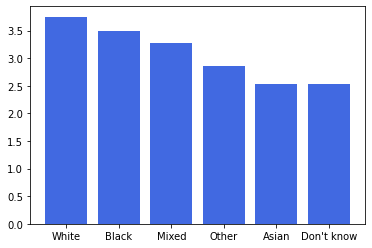

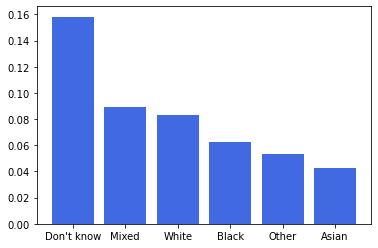

In [42]:
# Plotting bar charts showing % of severe and minor injuries by race
plt.figure()
injury = injury.sort_values('Injury: Minor', ascending = False)
plt.bar(injury['SubjectEthnicity'], injury['Injury: Minor'], color='royalblue')


plt.figure()
injury = injury.sort_values('Injury: Severe', ascending = False)
plt.bar(injury['SubjectEthnicity'], injury['Injury: Severe'], color = 'royalblue')

There is not considerable difference in the percentage of subjects being minorly injured in police force incidents by race. For severe injuries, the 'Don't know' category is quite a lot higher than the others, but not much insight can be gained from this as the name of the category suggests. There is only one death which is not enough to be statistically significant.

I now want to see if there is a difference between the medical attention provided and offered for different ethnicities.

<BarContainer object of 6 artists>

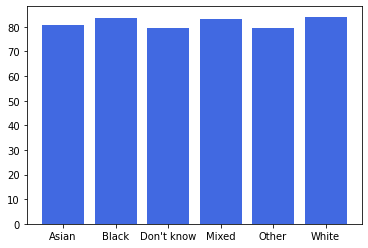

In [43]:
# selecting columns of interest
med_cols = ['Injury: Minor', 'Injury: Severe', 'SubjectMedOffered', 'SubjectMedProvided']
med = by_ethnicity[med_cols]

# calculating total injury rate
med = med.assign(InjuryTotal = med['Injury: Minor'] + med['Injury: Severe'])

# calculating percentage of injured subjects offered medical attention
med['MedOfferedperInjury'] = med['SubjectMedOffered']/med['InjuryTotal']*100


med = med.reset_index().rename(columns={'index':'SubjectEthnicity'})

plt.bar(med['SubjectEthnicity'], med['MedOfferedperInjury'], color='royalblue')

In [44]:
med

,SubjectEthnicity,Injury: Minor,Injury: Severe,SubjectMedOffered,SubjectMedProvided,InjuryTotal,MedOfferedperInjury
0,Asian,1492.0,25.0,1228.0,831.0,1517.0,80.949242
1,Black,5364.0,96.0,4561.0,3123.0,5460.0,83.534799
2,Don't know,144.0,9.0,122.0,91.0,153.0,79.738562
3,Mixed,515.0,14.0,441.0,304.0,529.0,83.364839
4,Other,594.0,11.0,480.0,327.0,605.0,79.338843
5,White,6989.0,155.0,6010.0,4402.0,7144.0,84.126540


Medical assistance to injured subject appears to be offered at the same rate to injured subjects, regarless of race.

Now I want to see if there is a difference in terms of the severity of violence by race in terms of taser and firearm usage.

In [45]:
taser_cols = ['CED Drawn',
       'CED Aimed', 'CED Red-Dotted', 'CED Arced','CED Drive Stun',
       'CED Fired', 'CED Angle Drive Stun', 'Firearms Aimed', 'Firearms Fired']

taser = by_ethnicity[taser_cols]

# calculating percentage of incidents that fall into each taser or firearm category 
    # as proportion of total incidents for that race
taser = taser.div(incidents_per_ethnicity, axis=0)*100
taser = taser.reset_index().rename(columns={'index':'SubjectEthnicity'})
taser

,SubjectEthnicity,CED Drawn,CED Aimed,CED Red-Dotted,CED Arced,CED Drive Stun,CED Fired,CED Angle Drive Stun,Firearms Aimed,Firearms Fired
0,Asian,1.756566,0.609351,2.595700,0.017021,0.005106,0.304676,0.005106,1.126789,0.003404
1,Black,2.711270,0.897452,4.031359,0.018262,0.015653,0.522427,0.006522,1.281608,0.005218
2,Don't know,3.393108,0.703235,3.094233,0.052743,0.017581,0.773558,0.000000,2.092124,0.035162
3,Mixed,2.048737,0.617166,2.875867,0.031813,0.006363,0.349940,0.000000,1.100719,0.006363
4,Other,1.661610,0.481626,2.191398,0.000000,0.009633,0.250446,0.000000,1.131821,0.004816
5,White,2.207295,0.648131,2.966488,0.019315,0.007511,0.390059,0.006975,0.707686,0.003219


Again, there is not really a considerable difference by ethnicity.

# 4. How is police violence changing over time?

## 4.1 Time Series Data Derivation

Since the police force data is in the form of rows of incidents over time, this can be transformed to a number of counts per day, which lends itself to Poisson regression modelling. This will be used to see how police force is trending over time.

In [385]:
# First, I will count the number of incidents per day 
    # (it doesn't matter which column I count as they are all the same length)
incidents_per_day = incidents.groupby(pd.Grouper(key='DateTime', freq='D'))['Borough'].count().reset_index()

# renaming the column to make sense 
incidents_per_day = incidents_per_day.rename(columns={'Borough': 'Incidents'})

# For the regression the variables are going to need to be numeric, not datetime objects
    # so, I am adding a column representing the number of days since the beggining of the data set
incidents_per_day['Day'] = (incidents_per_day.index - incidents_per_day.index[0])

incidents_per_day

,DateTime,Incidents,Day
0,2017-04-01,102,0
1,2017-04-02,115,1
2,2017-04-03,110,2
3,2017-04-04,102,3
4,2017-04-05,121,4
...,...,...,...
1456,2021-03-27,348,1456
1457,2021-03-28,322,1457
1458,2021-03-29,332,1458
1459,2021-03-30,378,1459


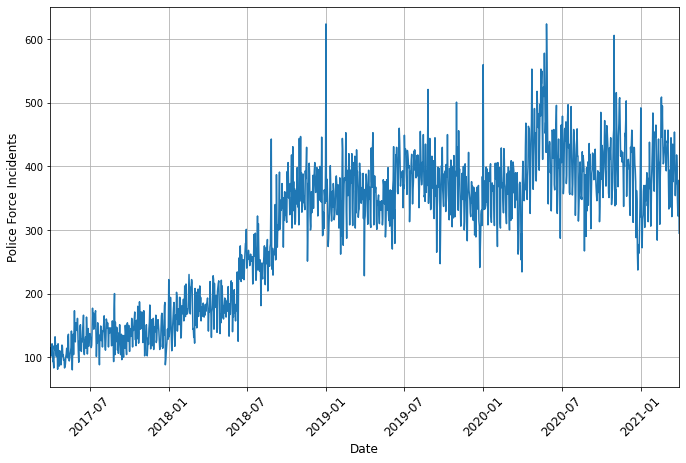

In [389]:
# a visualisation of the data to see the trend
plt.figure(figsize=(7*1.61,7))
plt.plot(incidents_per_day['DateTime'], incidents_per_day['Incidents'])

plt.xticks(rotation = 45, size=12)
plt.xlabel('Date', size=12)
plt.ylabel('Police Force Incidents', size=12)

plt.xticks(size=12)
plt.xlim(incidents_per_day['DateTime'].iloc[0], incidents_per_day['DateTime'].iloc[-1])
plt.grid()
plt.show()

From this visualisation, it can be seen that the number of incidents is generally increasing over time, however, it does not look uniform - it increases quite steeply around June 2018 and then levels off towards the end of the year into a shallower slope until now. It may be beneficial to truncate the beggining of the dataset, or fit two trends to the data set.

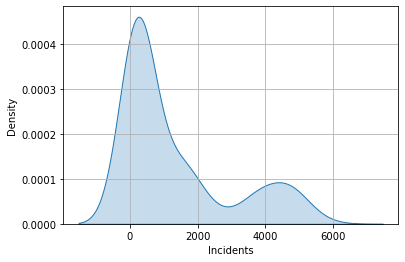

In [369]:
sns.kdeplot(incidents_per_day['Incidents'], shade=True)
plt.grid()
plt.show()

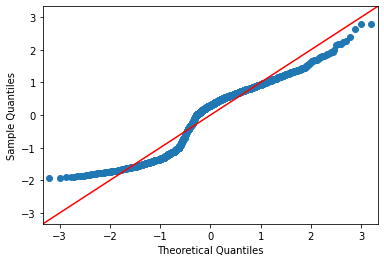

In [49]:
sm.qqplot(incidents_per_day['Incidents'],fit=True, line ='45')
plt.show()


A KDE plot of the incident count and QQ also confirm this - the distribution is clearly bimodal. So, I will truncate the data set and have another look.

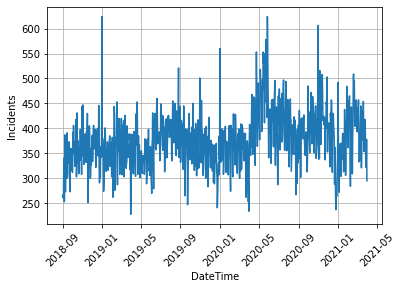

In [50]:
# the number of days to truncate was done qualitatively by changing the number and looking at the graph below
# the data set now starts at the beginning of September 2018
incidents_short = incidents_per_day.drop([i for i in range(518)]) 
sns.lineplot(x=incidents_short['DateTime'], y=incidents_short['Incidents'])
plt.xticks(rotation = 45)
plt.grid()
plt.show()

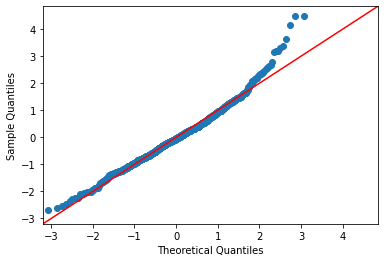

In [51]:
sm.qqplot(incidents_short['Incidents'],fit=True, line ='45')
plt.show()

The QQ plot now looks as expected for Poisson distributed data - with a right skew. So, I will proceed with this truncated data set.

## 4.2 Poisson Regression Model

Lots of information was retrieved from this website: https://timeseriesreasoning.com/contents/poisson-regression-model/

In [52]:
# Setting up the poisson model
expr = "Incidents ~ Day"
poisson_mdl = smf.glm(formula=expr, data=incidents_short, family=sm.families.Poisson()).fit()
poisson_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Incidents   No. Observations:                  943
Model:                            GLM   Df Residuals:                      941
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7033.7
Date:                Thu, 23 Dec 2021   Deviance:                       6749.6
Time:                        10:07:25   Pearson chi2:                 6.79e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.5471
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7646      0.006    901.042      0.000       5.752       5.777
Day            0.0002   6.16e-06     27.320      0.000       0.000       0.000
==============================================================================
"""

We can see that the deviance and pearson chi2 values for this model are very large, so this probably isn't a very good fit. This is likely due to the key assumption of the Poission model that the mean is equal to the variance being violated. We can estimate the dispersion (i.e if the variance is different from the mean) by taking the raio of the deviance to the degrees of freedom. This information is from: https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html#sec-overdispPois

In [53]:
poisson_mdl.deviance/ poisson_mdl.df_resid

7.17279029091203

This value is quite a lot more than 1, meaning there is significant overdispersion, meaning the variance is larger than assumed by the poisson model. So, now, I will fit a Negative Binomial model which does not have the mean = variance assumption, so can handle the overdispersion.

## 4.3 Negative Binomial Regression Model

In [54]:
nb_mdl = smf.glm(formula=expr, data=incidents_short, family=sm.families.NegativeBinomial()).fit()
nb_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Incidents   No. Observations:                  943
Model:                            GLM   Df Residuals:                      941
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6537.4
Date:                Thu, 23 Dec 2021   Deviance:                       17.829
Time:                        10:07:26   Pearson chi2:                     17.8
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002117
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7628      0.123     46.899      0.000       5.522       6.004
Day            0.0002      0.000      1.422      0.155   -6.45e-05       0.000
==============================================================================
"""

To see if the negative binomial model has fit better than the poisson, I will calculate the likelihood ratio:

In [55]:
-2*(poisson_mdl.llf - nb_mdl.llf)

992.5857860260166

This is much larger than the critical value of chi squared, indicating that the NB is a much better fit than poisson. To quantify the goodness of fit of the NB by itself, we can look at the deviance and pearson chi squared compared to the chi squared statistic at the 95% confidence level with 942 degrees of freedom:

In [56]:
stats.chi2.ppf(0.05, 942)

871.7599929912574

This value is much larger than the pearson chi2 and disperson, indicating that the NB model is a good fit, so I will proceed with this model. Below is what the NB fit looks like.

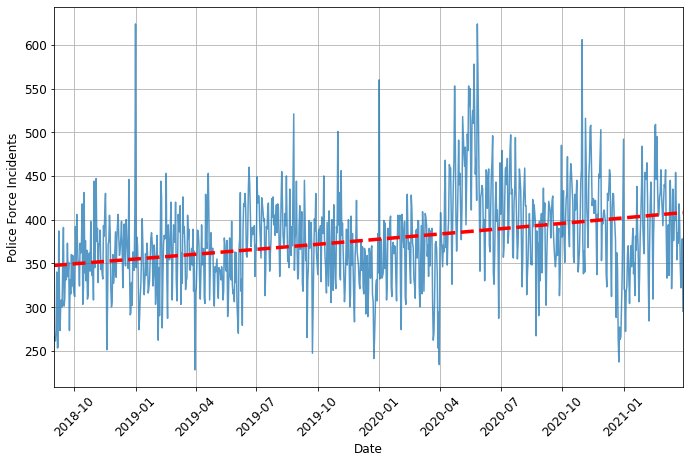

In [399]:
# Plotting the fitted line
pred_vals = nb_mdl.predict()

plt.figure(figsize=(7*1.61,7))
plt.plot(incidents_short['DateTime'],incidents_short['Incidents'],alpha=0.75)
plt.plot(incidents_short['DateTime'], pred_vals, lw=3.5, ls='--', color='r', label='Negative Binomial Fit')

plt.xticks(rotation = 45, size=12)
plt.xlabel('Date', size=12)
plt.ylabel('Police Force Incidents', size=12)

plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim(incidents_short['DateTime'].iloc[0], incidents_short['DateTime'].iloc[-1])
plt.grid()
plt.show()

<Figure size 811.44x504 with 0 Axes>

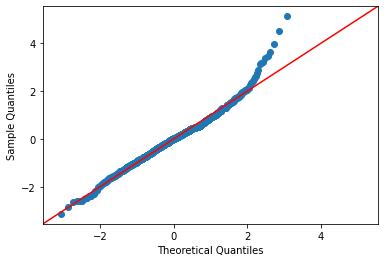

In [397]:
# Calculating and making a QQ plot of residuals

res = incidents_short['Incidents'] - pred_vals
plt.figure(figsize=(7*1.61,7))
sm.qqplot(res,fit=True, line ='45')

plt.show()

Looking at the QQ plot, the fit is still not ideal and it has some skew. This is likely due to autocorrelation in the data, however, this will not be explored now as the model is good enough to gain some insight, even if it could be improved. To deal with the autocorrelation, the data could be examined for seasonality, or a different model could be used to take account of it.

In [68]:
# Implementing k fold cross validation to estimate the generalisation error of our model
llf, dev, chi2 = [], [], []
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
for train_idx, test_idx in kfold.split(incidents_short):
    X_train, X_test = incidents_short.iloc[train_idx], incidents_short.iloc[test_idx]
    y_test = incidents_short.iloc[test_idx,1]
    model = smf.glm(formula = expr, data=X_train, 
                    family=sm.families.NegativeBinomial()).fit()
    preds = model.predict(X_test)
    res = y_test - preds
    llf.append(model.llf)
    dev.append(model.deviance)
    chi2.append(model.pearson_chi2)
llf_mean = np.array(llf).mean()
dev_mean = np.array(dev).mean()
chi2_mean = np.array(chi2).mean()
print(llf_mean, dev_mean, chi2_mean) # The validation goodness of fit measures are very similar to the training ones

-5883.624970641964 16.043345426513707 16.05843811031897


## 4.4 Proportion of Ethnicity over Time

Next, I will see if the proportion of incidents by ethnicity is changing over time.

In [69]:
# encoding the SubjectEthnicity Column so that the counts per by ethnicity can be found
dummy_ethnicity = pd.get_dummies(incidents['SubjectEthnicity'])
ethnicity_cols = ['Asian (or Asian British)','Black (or Black British)','Chinese', 
                  "Don't know",'Mixed','Other','White']
incidents_eth_encoded = pd.concat([incidents, dummy_ethnicity], axis=1)

incidents_daily_ethnicity = incidents_eth_encoded.groupby(pd.Grouper(key='DateTime', freq='D'))[ethnicity_cols].sum()
incidents_daily_ethnicity = incidents_daily_ethnicity.reset_index()

incidents_daily_ethnicity = pd.merge(incidents_per_day, incidents_daily_ethnicity)

# Calculating percentage of incidents by ethnicity
for eth in ethnicity_cols:
    incidents_daily_ethnicity[eth] = incidents_daily_ethnicity[eth]*100/incidents_daily_ethnicity['Incidents']

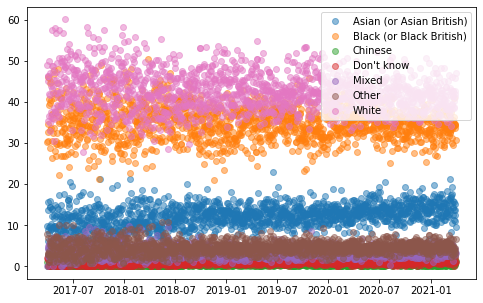

In [70]:
plt.figure(figsize=(5*1.61,5))
for eth in ethnicity_cols:
    plt.plot(incidents_daily_ethnicity["DateTime"], incidents_daily_ethnicity[eth],'o',alpha=0.5, label=eth)

plt.legend()

There seeems to be a slight upward trend in the proportion of incidents affecting Asian (or Asian British people), and a corresponding downward trend in the White and Black (or Black British) categories. I will calulate pearson's r squared coefficient for these categories against time to see if this warrants further investigation.

In [71]:
time = incidents_daily_ethnicity["Day"]
corr_asian = pearsonr(time, incidents_daily_ethnicity['Asian (or Asian British)'])
corr_black = pearsonr(time, incidents_daily_ethnicity['Black (or Black British)'])
corr_white = pearsonr(time, incidents_daily_ethnicity['White'])
corr_asian[0], corr_black[0], corr_white[0]

(0.40053433168585895, -0.12776434677192247, -0.17199476968499294)

These values aren't large enough to warrant further modelling.

# 5. Is there a link between crime levels and the use of force by the Metropolitan Police?

Finally, I will explore if there is any justification for the increasing police force levels, by seeing if it is related to increasing crime. This will incorporate the Met Police crime data.

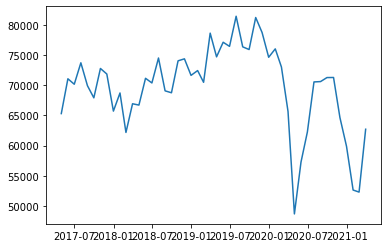

In [401]:
# visualisation of total crime over time
plt.plot(crime_totals['Date'], crime_totals['Total Crime'])

In [403]:
# regrouping incident data by month so that it matches with crime data
incidents_per_month = incidents.groupby(pd.Grouper(key='DateTime', freq='M'))['Borough'].count().reset_index()

# renaming the column to make sense 
incidents_per_month = incidents_per_month.rename(columns={'Borough': 'Incidents'})

In [404]:
# getting the crime data from earlier
incidents_per_month['Crime'] = crime_totals['Total Crime']
incidents_per_month['Violent Crime'] = crime_totals['Violent Crime']
incidents_per_month['Non-Violent Crime'] = crime_totals['Non-Violent Crime']

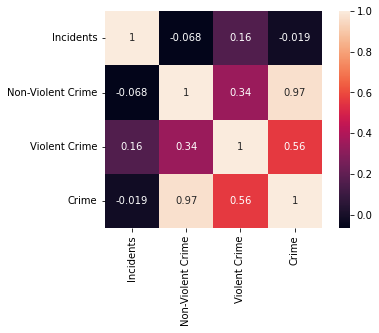

In [75]:
crime_cols = ['Incidents','Non-Violent Crime','Violent Crime','Crime']
corrMatrix = incidents_per_day[crime_cols].corr()
ax = sns.heatmap(corrMatrix, annot=True, square=True)
#ax.set_yticklabels(['Police Force Incidents','2','3','4'])
plt.show()

Surprisingly, there is no significant relationship between police force incidents and crime according to the r value, regardless of crime type. 

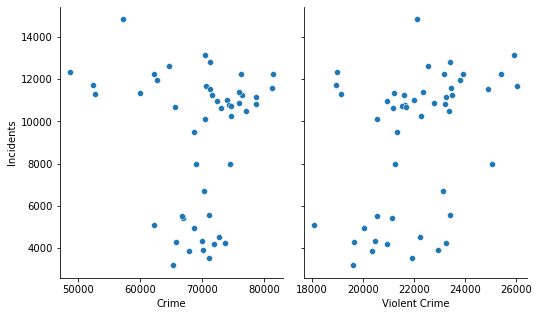

In [427]:
# quick visualisation to check there is no relationship
sns.pairplot(data=incidents_per_month, x_vars=['Crime','Violent Crime'], y_vars='Incidents')
plt.gcf().set_size_inches(5*1.61, 5)
plt.show()